<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/tool_comparison/adult_census/kerasTuner_WideDeepModel_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q keras-tuner
%pip show keras-tuner scikit-learn

     |████████████████████████████████| 61kB 3.2MB/s 
Name: keras-tuner
Version: 1.0.1
Summary: Hypertuner for Keras
Home-page: https://github.com/keras-team/keras-tuner
Author: The Keras Tuner authors
Author-email: kerastuner@google.com
License: Apache License 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: requests, future, scikit-learn, tabulate, colorama, tqdm, terminaltables, scipy, numpy
Required-by: 
---
Name: scikit-learn
Version: 0.22.2.post1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, joblib, scipy
Required-by: yellowbrick, umap-learn, textgenrnn, sklearn, sklearn-pandas, mlxtend, lucid, lightgbm, librosa, keras-tuner, imbalanced-learn, fancyimpute


In [2]:
import IPython, os, pprint

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from kerastuner import HyperModel, Hyperband
from tensorflow.keras.experimental import LinearModel, WideDeepModel
from tensorflow.keras import Sequential, Input, layers, optimizers, callbacks
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.utils import plot_model

## データセット読み込み
- [国税調査データセット:https://www.openml.org/d/1590](https://www.openml.org/d/1590)

In [3]:
%%time
DATA_ID = '1590' #@param{type:'string'}

# データセットをフェッチ
result = fetch_openml(data_id=DATA_ID,
                    as_frame=True)
X = result.data
y = result.target
x_cols = result.feature_names
y_col = result.target_names

display(x_cols)
display(X.head())
display(y_col)
display(y.head())


def proc_y(y):
    '''ラベルの加工'''

    def _one_hot_encode(y):
        '''ワンホットエンコードしたnumpy.ndarrayを返す'''
        return pd.get_dummies(y)

    proc_y = _one_hot_encode(y=y)
    return proc_y


def proc_X(X, one_hot_encode_cols):
    '''特徴量の加工'''

    def _one_hot_encode(X, X_cols, drop_first=True):
        '''ワンホットエンコードしたDataframeを返す'''
        return pd.get_dummies(X, columns=X_cols,
                              drop_first=drop_first)

    proc_X = _one_hot_encode(X=X, X_cols=one_hot_encode_cols)
    return proc_X


one_hot_encode_cols = ['workclass', 'education', 'marital-status', 'occupation',
                       'relationship', 'race', 'sex', 'native-country']
X=proc_X(X=X, one_hot_encode_cols=one_hot_encode_cols)
y=proc_y(y=y)

display(X.head())
display(y.head())


SEED = 7 #@param{type:'number'}
SPLIT = 0.2 #@param{type:'number'}

train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size=SPLIT,
                                                    random_state=SEED,
                                                    shuffle=True)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y,
                                                  test_size=SPLIT,
                                                  random_state=SEED,
                                                  shuffle=True)

display('train shape:{}'.format(train_X.shape))
display('val shape:{}'.format(val_X.shape))
display('test shape:{}'.format(test_X.shape))



['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country']

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States


['class']

0    <=50K
1    <=50K
2     >50K
3     >50K
4    <=50K
Name: class, dtype: category
Categories (2, object): ['>50K', '<=50K']

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Self-emp-not-inc,workclass_Self-emp-inc,workclass_Federal-gov,workclass_Local-gov,workclass_State-gov,workclass_Without-pay,workclass_Never-worked,education_Some-college,education_11th,education_HS-grad,education_Prof-school,education_Assoc-acdm,education_Assoc-voc,education_9th,education_7th-8th,education_12th,education_Masters,education_1st-4th,education_10th,education_Doctorate,education_5th-6th,education_Preschool,marital-status_Divorced,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,marital-status_Married-spouse-absent,marital-status_Married-AF-spouse,occupation_Craft-repair,occupation_Other-service,occupation_Sales,occupation_Exec-managerial,occupation_Prof-specialty,occupation_Handlers-cleaners,...,native-country_Cambodia,native-country_England,native-country_Puerto-Rico,native-country_Canada,native-country_Germany,native-country_Outlying-US(Guam-USVI-etc),native-country_India,native-country_Japan,native-country_Greece,native-country_South,native-country_China,native-country_Cuba,native-country_Iran,native-country_Honduras,native-country_Philippines,native-country_Italy,native-country_Poland,native-country_Jamaica,native-country_Vietnam,native-country_Mexico,native-country_Portugal,native-country_Ireland,native-country_France,native-country_Dominican-Republic,native-country_Laos,native-country_Ecuador,native-country_Taiwan,native-country_Haiti,native-country_Columbia,native-country_Hungary,native-country_Guatemala,native-country_Nicaragua,native-country_Scotland,native-country_Thailand,native-country_Yugoslavia,native-country_El-Salvador,native-country_Trinadad&Tobago,native-country_Peru,native-country_Hong,native-country_Holand-Netherlands
0,25.0,226802.0,7.0,0.0,0.0,40.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,38.0,89814.0,9.0,0.0,0.0,50.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,28.0,336951.0,12.0,0.0,0.0,40.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,44.0,160323.0,10.0,7688.0,0.0,40.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18.0,103497.0,10.0,0.0,0.0,30.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,>50K,<=50K
0,0,1
1,0,1
2,1,0
3,1,0
4,0,1


'train shape:(31258, 97)'

'val shape:(7815, 97)'

'test shape:(9769, 97)'

CPU times: user 1.37 s, sys: 69.3 ms, total: 1.43 s
Wall time: 3.29 s


## Hyperモデル作成

In [4]:
%%time
class CensusHyperModel(HyperModel):

      def __init__(self, input_shape_dnn, num_class, dropout_seed, train_X_dnn):
          self.input_shape_dnn = input_shape_dnn
          self.num_class = num_class
          self.dropout_seed = dropout_seed
          self.norm_layer = self._setupNormalizationLayer(X=train_X_dnn)

      def _setupNormalizationLayer(self, X):
          '''正規化の前処理レイヤーを初期化'''
          norm_layer = layers.experimental.preprocessing.Normalization()
          norm_layer.adapt(X)
          return norm_layer


      def build(self, hp):
          '''モデル構造と探索空間の定義'''
          
          def _LinearModel_fn(self):
              '''線形回帰モデルの定義'''
              linear_model = LinearModel(units=self.num_class,
                                        activation='softmax')
              return linear_model


          def _DNNModel_fn(self, hp):
              '''DNNモデルの定義'''
              model = Sequential()
              model.add(layers.Input(shape=self.input_shape_dnn))

              hp_processing_layer = hp.Boolean('is_processing_layer', default=False)
              if hp_processing_layer:
                  model.add(self.norm_layer)
                
              for i in range(hp.Int('num_layers', min_value=2, max_value=7, step=1)):
                  units = hp.Int('units_'+str(i), min_value=32, max_value=512, step=32)
                  model.add(layers.Dense(units=units, activation='relu'))
                  model.add(layers.Dropout(rate=0.3, seed=self.dropout_seed))
              
              model.add(layers.Dense(self.num_class, activation='softmax'))
              return model


          linear_model = _LinearModel_fn(self=self)
          dnn_model = _DNNModel_fn(self=self, hp=hp)
    
          combined_model = WideDeepModel(linear_model=linear_model,
                                        dnn_model=dnn_model,
                                        activation='softmax')

          # 勾配アルゴリズム(線形モデル用, 深層モデル用), 損失関数, 評価関数
          combined_model.compile(optimizer=['sgd', optimizers.Adam(hp.Choice('learning_rate', [1e-1, 1e-3, 1e-4]))],
                                loss='categorical_crossentropy', 
                                metrics=['accuracy', 'categorical_crossentropy'])
          
          return combined_model


def take_linear_and_dnn_cols(fetch_X_cols, encoded_cols, df_cols):
    '''DNNと線形モデル用のカラム名を返す
    INFO : WideDeepModel用'''
    dnn_cols = set(fetch_X_cols) ^ set(encoded_cols)
    linear_cols = set(df_cols) ^ set(dnn_cols)
    return linear_cols, dnn_cols


linear_cols, dnn_cols = take_linear_and_dnn_cols(x_cols, one_hot_encode_cols, X.columns)
# DNNモデルの入力に使用する特徴量の取得
train_X_dnn = train_X.loc[:, dnn_cols].values
input_shape_dnn = (train_X.loc[:, dnn_cols].shape[1], )
# 線形回帰モデルが使用する特徴量名の取得
linear_cols = train_X.drop(columns=dnn_cols).columns

# 出力層のユニット数
num_class = train_y.shape[1]

# モデル定義
hyper_model = CensusHyperModel(train_X_dnn=train_X_dnn, 
                                input_shape_dnn=input_shape_dnn,
                                num_class=num_class,
                                dropout_seed=SEED)

display(hyper_model)


def X_data_WideDeep_fn(X_df, linear_cols, dnn_cols):
    '''WideDeepモデル用の特徴量データセットの作成'''
    return [X_df[linear_cols].values, X_df[dnn_cols].values]


train_X_WideDeep = X_data_WideDeep_fn(X_df=train_X, linear_cols=linear_cols, dnn_cols=dnn_cols)
val_X_WideDeep = X_data_WideDeep_fn(X_df=val_X, linear_cols=linear_cols, dnn_cols=dnn_cols)
test_X_WideDeep = X_data_WideDeep_fn(X_df=test_X, linear_cols=linear_cols, dnn_cols=dnn_cols)

CPU times: user 63.4 ms, sys: 18.9 ms, total: 82.2 ms
Wall time: 225 ms


In [13]:
# Hyperbandアルゴリズム自体の試行回数(default:1)
HYPERBAND_ITERATIONS = 1 #@param{type:'number'}
# バケット内のモデルを選択する際の割合(default:3)
FACTOR = 3 #@param{type:'number'}
# モデル1つあたりの最大Epoch数
MAX_EPOCHS = 50 #@param{type:'number'}
# バケット1つあたりで試行されるパラメータ候補の数
PARAMETER_CANDIDATES =  10# @param{type:'number'}
BATCH_SIZE = 1024 #@param{type:'number'}

tuner = Hyperband(hypermodel=hyper_model,
                  objective='val_accuracy',
                  hyperband_iterations=HYPERBAND_ITERATIONS,
                  factor=FACTOR,
                  max_epochs=MAX_EPOCHS,
                  seed=SEED
                  )
display(tuner)

# 早期停止コールバックの定義
es = callbacks.EarlyStopping(monitor='val_loss',
                             patience=5)

class ClearTrainingOutput(callbacks.Callback):
    '''Ipythonログをクリアするコールバックのクラス定義'''
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [6]:
%%time
tuner.search(x=train_X_WideDeep, y=train_y,
             epochs=PARAMETER_CANDIDATES,
             batch_size=BATCH_SIZE,
             validation_data=(val_X_WideDeep, val_y),
             callbacks=[es, ClearTrainingOutput()],
             verbose=1)

INFO:tensorflow:Oracle triggered exit
CPU times: user 2h 11min 12s, sys: 9min 36s, total: 2h 20min 48s
Wall time: 1h 45min 2s


# モデルの構造を可視化

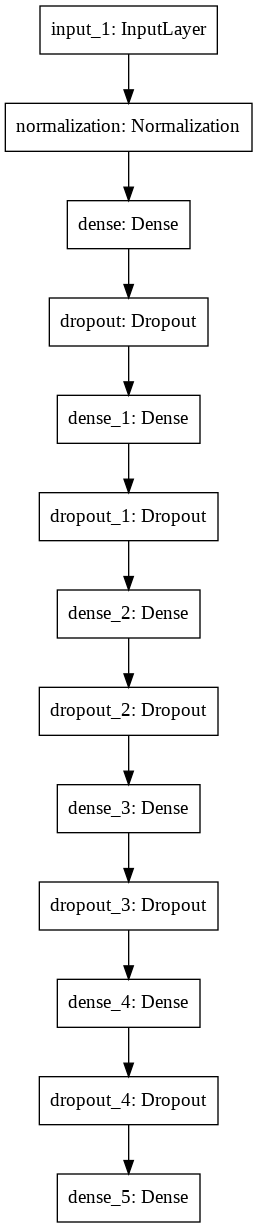

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 448)               29120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 448)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 192)               86208     
_________________________________________________________________
dropout_2 (Dropout)          (None, 192)               0

None

CPU times: user 388 ms, sys: 61.1 ms, total: 449 ms
Wall time: 524 ms


In [11]:
%%time
def take_best_model(tuner):
    '''ベストなモデルの取り出し'''
    best_model = tuner.get_best_models(num_models=1)[0]
    return best_model


def display_dnn_model(dnn_model):
    '''DNNの構造を表示'''
    display(plot_model(dnn_model))
    display(dnn_model.summary())


classifier = take_best_model(tuner)
display_dnn_model(dnn_model=classifier.dnn_model)

## モデルの評価

### Kerasの組み込み評価関数

In [18]:
%%time
classifier.evaluate(x=test_X_WideDeep, y=test_y, batch_size=BATCH_SIZE)

10/10 [==============================] - 0s 15ms/step - loss: 0.3792 - accuracy: 0.8477 - categorical_crossentropy: 0.3792
CPU times: user 307 ms, sys: 15.7 ms, total: 323 ms
Wall time: 237 ms


[0.37922215461730957, 0.84768146276474, 0.37922215461730957]

### sklearnの評価関数

In [19]:
%%time
def predict_classes(model, x):
    '''ラスラベルの予測を取得'''
    return np.argmax(model.predict(x), axis=-1)


# 予測結果の取得
train_y_pred = predict_classes(classifier, train_X_WideDeep)
val_y_pred = predict_classes(classifier, val_X_WideDeep)
test_y_pred = predict_classes(classifier, test_X_WideDeep)


def encode_label_classes(one_hot_encode_y):
    '''ワンホットエンコードをラベルエンコードに変換'''
    return np.argmax(one_hot_encode_y.values, axis=-1)

train_report = classification_report(y_true=encode_label_classes(train_y),
                                     y_pred=train_y_pred)
val_report = classification_report(y_true=encode_label_classes(val_y),
                                   y_pred=val_y_pred)
test_report = classification_report(y_true=encode_label_classes(test_y),
                                    y_pred=test_y_pred)

print(train_report)
print('----- -----')
print(val_report)
print('----- -----')
print(test_report)

              precision    recall  f1-score   support

           0       0.79      0.52      0.63      7477
           1       0.86      0.96      0.91     23781

    accuracy                           0.85     31258
   macro avg       0.83      0.74      0.77     31258
weighted avg       0.85      0.85      0.84     31258

----- -----
              precision    recall  f1-score   support

           0       0.81      0.53      0.64      1900
           1       0.86      0.96      0.91      5915

    accuracy                           0.86      7815
   macro avg       0.84      0.75      0.78      7815
weighted avg       0.85      0.86      0.84      7815

----- -----
              precision    recall  f1-score   support

           0       0.79      0.49      0.60      2310
           1       0.86      0.96      0.91      7459

    accuracy                           0.85      9769
   macro avg       0.82      0.72      0.75      9769
weighted avg       0.84      0.85      0.83      9